In [26]:
import csv
from pathlib import Path
import logging as log
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#plt.rcParams.update(params)


log.basicConfig(level=log.INFO)

all_data_path = Path('all-stats-summary.tsv')

In [27]:
def read_all(path):
    data = [[]]
    head = None
    with path.open() as p:
        for i, line in enumerate(p):
            #line = line.strip()
            if i == 0:
                head = line.split('\t')
                continue
            if not line.strip():
                # empty lines separate suit
                data.append([])
                continue
            rec = line.split('\t')
            if len(rec) != len(head):
                log.warning(f'skip: {line}')
                continue
            assert len(rec) == len(head)
            for i in range(1, len(rec)):
                if rec[i] == 'Chars':
                    rec[i] = "100"  # some placeholder
                cell = rec[i].replace(',', '').strip()
                rec[i] = float(cell) if cell else None
            data[-1].append(rec)
    return head, data
header, all_data = read_all(all_data_path)
print(len(all_data), sum(1 for grp in all_data for ex in grp))

11 106


In [4]:
def raw_to_heat(data, col_name, colx, coly, colz):    
    res = []
    for grp in data:
        buffer = np.zeros((len(grp), 3), dtype=np.float)
        for idx, rec in enumerate(grp):
            name = rec[col_name].split('/')[0].replace('runs-', '').upper()
            x, y, z = rec[colx], rec[coly], rec[colz]
            buffer[idx] = np.array([x, y, z])
        buffer[:, 2] -= np.max(buffer[:, 2])
        res.append((name, buffer))
    return res

col_name = header.index('Experiment')
col_1 = header.index('tgt_mean_len')
col_2 = header.index('tgt_EMD')
col_y = header.index('BLEU_dev')
#header
heat_data = raw_to_heat(all_data, col_name, col_1, col_2, col_y)

In [4]:
from matplotlib import pyplot as plt

def contour_plot(x, y, z, title=None, xscale='log', yscale='linear'):  
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    #levels = int((np.max(z) - np.min(z)) / 0.1)
    levels = 30
    z = [max(-3, ze) for ze in z]  # max -1
    ax.tricontour(x, y, z, levels=levels, linewidths=0.5, colors='k')
    cntr = ax.tricontourf(x, y, z, levels=levels, cmap="RdBu_r")

    fig.colorbar(cntr, ax=ax)
    ax.plot(x, y, 'ko', ms=3)
    ax.set(xlim=(np.min(x)*0.98, np.max(x)*1.1), ylim=(0.95*np.min(y), 1.1*np.max(y)))
    ax.set_title('tricontour (%d points)' % len(x))
    plt.xscale(xscale)
    plt.yscale(yscale)    
    if title:
        plt.title(title)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    

for name, grp in heat_data[:0]:
    contour_plot(grp[:, 0], grp[:, 1], grp[:, 2], title=name)

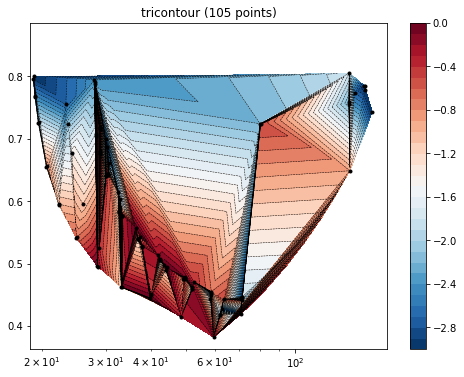

In [5]:
combined = np.concatenate([d for n, d in heat_data], axis=0)
contour_plot(combined[:,0], combined[:,1], combined[:,2])

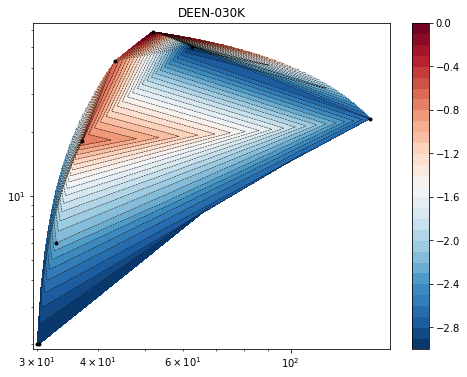

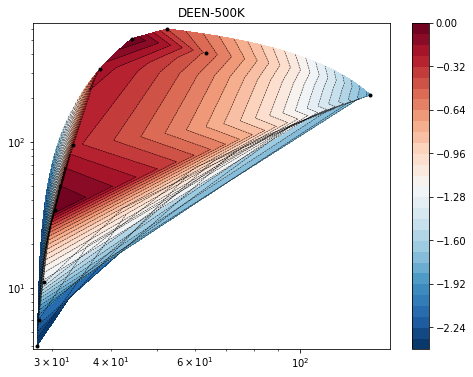

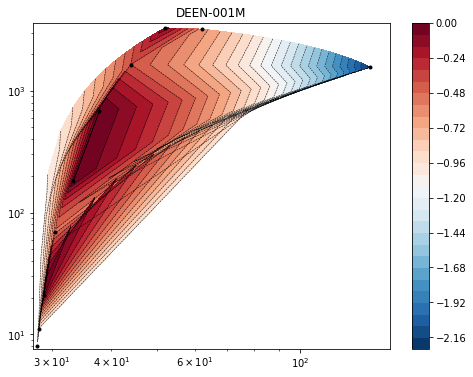

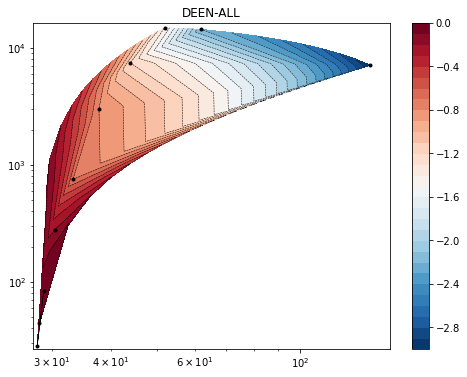

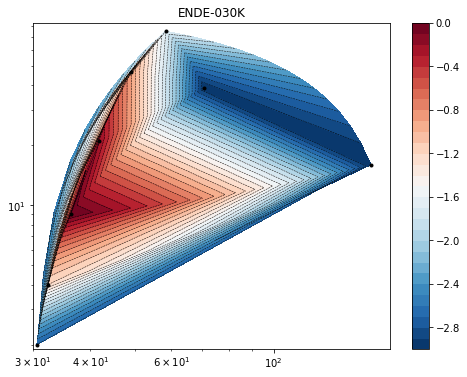

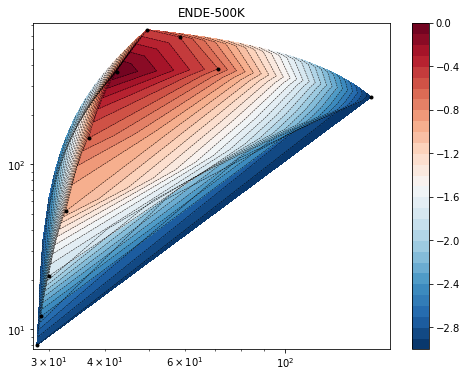

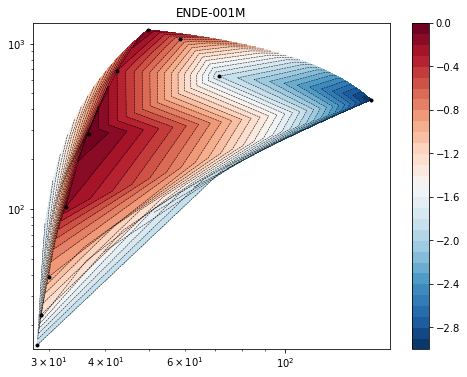

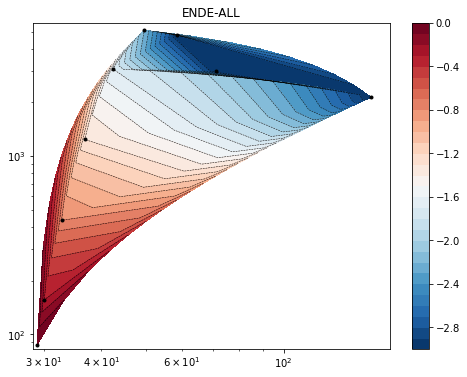

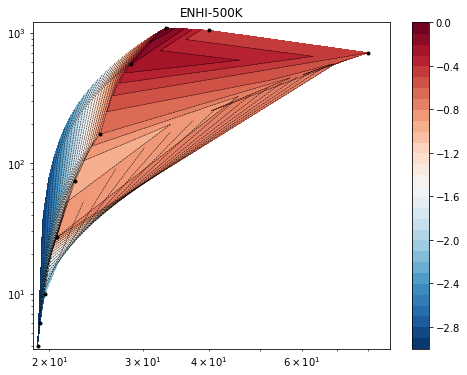

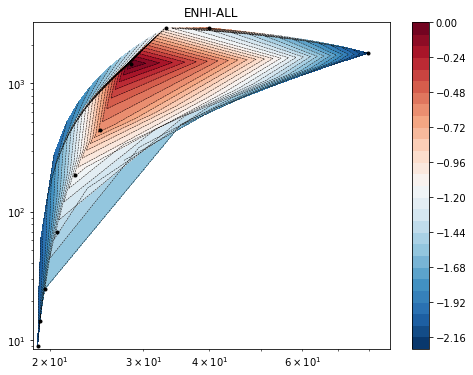

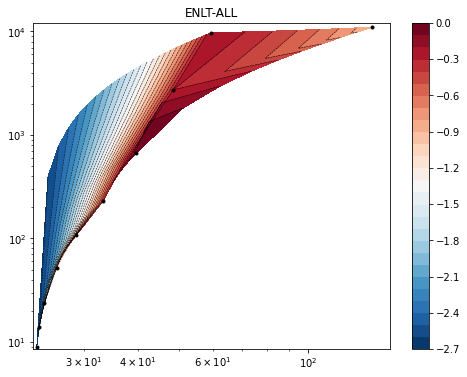

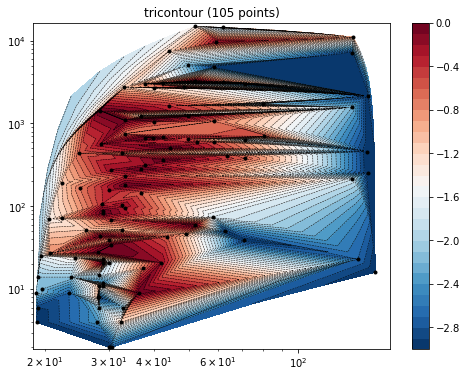

In [6]:
col_name = header.index('Experiment')
col_1 = header.index('tgt_mean_len')
col_2 = header.index('tgt_f95p')
col_y = header.index('BLEU_dev')
#header
heat_data2 = raw_to_heat(all_data, col_name, col_1, col_2, col_y)
for name, grp in heat_data2:
    contour_plot(grp[:, 0], grp[:, 1], grp[:, 2], title=name, yscale='log')
combined2 = np.concatenate([d for n, d in heat_data2], axis=0)
contour_plot(combined2[:,0], combined2[:,1], combined2[:,2], yscale='log')

# visualize  three axis plot

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

    
def three_axes_plot(x, y1, y2, y3, legends, y_maxs=None, title=None, y_mins=None, save=None, 
                    figsize=(8, 6), y2_scale=None):
    assert len(legends) == 4 # [x, y1, y2, y3]

    fig, host = plt.subplots(figsize=figsize)
    fig.tight_layout()   
    fig.subplots_adjust(bottom=0.125, left=0.13, top=0.88, right=0.82)

    par1 = host
    par2 = host.twinx()
    par3 = host.twinx()

    # Offset the right spine of par3.  The ticks and label have already been
    # placed on the right by twinx above.
    par3.spines["right"].set_position(("axes", 1.15))
    # Having been created by twinx, par3 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par3.spines["right"].set_visible(True)

    p1, = par1.plot(x, y1, "g-o", label=legends[1])
    p2, = par2.plot(x, y2, "r--o", label=legends[2])
    p3, = par3.plot(x, y3, "b-.o", label=legends[3])

    y_mins = y_mins or [0] * 3
    y_maxs = y_maxs or [max(line) * 1.1 for line in [y1, y2, y3]]
    assert len(y_maxs) == 3     
    assert len(y_mins) == 3     
    par1.set_ylim(y_mins[0], y_maxs[0])
    par2.set_ylim(y_mins[1], y_maxs[1])
    par3.set_ylim(y_mins[2], y_maxs[2])

    par1.set_xlabel(legends[0])
    par1.set_ylabel(legends[1])
    par2.set_ylabel(legends[2])
    par3.set_ylabel(legends[3])

    par1.yaxis.label.set_color(p1.get_color())
    par2.yaxis.label.set_color(p2.get_color())
    par3.yaxis.label.set_color(p3.get_color())
    
    if y2_scale:
        par2.set_yscale(y2_scale)

    tkw = dict(size=4, width=1.5)
    par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par3.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]

    host.legend(lines, [l.get_label() for l in lines], loc='upper left', ncol=2, fancybox=False)

    if title:
        plt.title(title)
    if save:
        print(f'saving to {save}')
        plt.savefig(save)
    plt.show()

#y_maxs = [25, 180, 1]

def to_3ax_data(head, data, y1='tgt_mean_len', y2='tgt_EMD', y3='BLEU_dev', x='Experiment'):
    x_idx = head.index(x)
    y1_idx = head.index(y1)
    y2_idx = head.index(y2)
    y3_idx = head.index(y3)
    res = []
    for grp in data:
        buf = np.zeros((len(grp), 3), dtype=np.float)
        xs = [None] * len(grp)
        grp_name = None
        for i, ex in enumerate(grp):
            x = ex[x_idx]
            grp_name, x_name = x.split('/')
            xs[i] = x_name.split('-')[2]
            grp_name = grp_name.replace('runs-', '')
            buf[i, 0] = ex[y1_idx]
            buf[i, 1]= ex[y2_idx]
            buf[i, 2]= ex[y3_idx]
        res.append((grp_name, xs, buf))
    return res


tgt_f95p


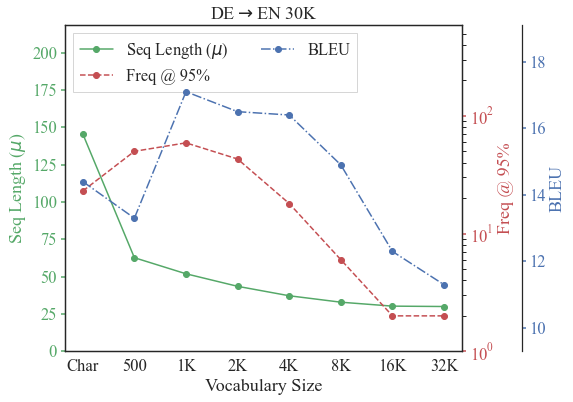

tgt_EMD


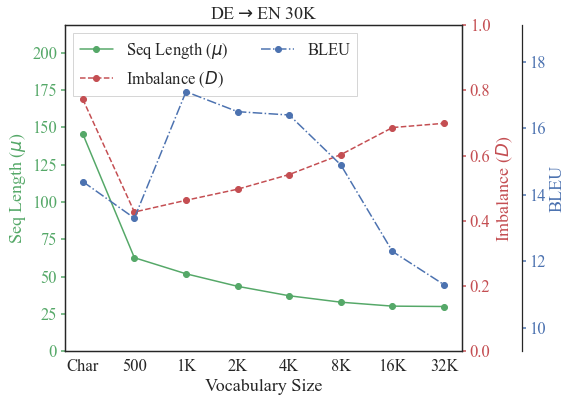

In [7]:

vocab_name = {
    'chars' : 'Char',
    '.5k.5k': '500',
    '01k01k': '1K',
    '02k02k': '2K',
    '04k04k': '4K',
    '08k08k': '8K', 
    '16k16k': '16K',
    '32k32k': '32K',    
    '48k48k': '48K',        
    '64k64k': '64K'    
}
name_name = {
    'deen-030k': r'DE$\rightarrow$EN 30K',
    'deen-500k': r'DE$\rightarrow$EN 0.5M',
    'deen-001m': r'DE$\rightarrow$EN 1M',
    'deen-all': r'DE$\rightarrow$EN 4.5M',
    'ende-030k': r'EN$\rightarrow$DE 30K',
    'ende-500k': r'EN$\rightarrow$DE 0.5M',
    'ende-001m': r'EN$\rightarrow$DE 1M',
    'ende-all': r'EN$\rightarrow$DE 4.5M',
    'enhi-500k': r'EN$\rightarrow$HI 0.5M',
    'enhi-all': r'EN$\rightarrow$HI 1.3M',
    'enlt-all': r'EN$\rightarrow$LT 0.6M',
}


sns.set(font="Times New Roman", style='white',font_scale=1.5)


y2_fields = [
    ('tgt_f95p', r'Freq @ 95%', None, 'log', 'freq95p'),
    ('tgt_EMD', r'Imbalance ($D$)', 1.0 ,'linear', 'D')
]
for y2_field, y2_name, y2_max, y2_scale, save_name in y2_fields:
    data_3ax = to_3ax_data(header, all_data, y2=y2_field)
    legends = ['Vocabulary Size'] + [r'Seq Length ($\mu$)', y2_name, 'BLEU']
    c = 0 
    print(f"{y2_field}")    
    for name, xs, ys in data_3ax:
        xs = [vocab_name[x] for x in xs]
        name = name_name[name]
        
        if y2_field == 'tgt_f95p':  # log scale
            y2_min, y2_max = 1, 10 * max(ys[:,1]) 
        else:
            y2_min, y2_max = 0, 1
        
        y_maxs = [1.5 * max(ys[:,0]), y2_max, 2 + max(ys[:,2])]
        y_mins = [0,  y2_min, max(0, -2 + min(ys[:,2]))]
        save_to = 'viz/' + save_name
        save_to += '-' + name.replace(r'$\rightarrow$', '').replace(' ', '-').lower() + '.pdf'
        save_to = None # dont save
        three_axes_plot(x=xs, y1=ys[:,0], y2=ys[:,1], y3=ys[:,2], title=name,
                        legends=legends, y_maxs=y_maxs, y_mins=y_mins, y2_scale=y2_scale, save=save_to)
        c += 1
        if c  >= 1:
            break
            

        

In [8]:
header

['Experiment',
 'n:',
 'src_toks',
 'src_mean_len',
 'src_EMD',
 'src_effective_n',
 'src_f90p',
 'src_f95p',
 'src_f98p',
 'src_f99p',
 'src_f100p',
 'tgt_toks',
 'tgt_mean_len',
 'tgt_EMD',
 'tgt_effective_n',
 'tgt_f90p',
 'tgt_f95p',
 'tgt_f98p',
 'tgt_f99p',
 'tgt_f100p',
 'BLEU_dev',
 'prec_corr_dev',
 'recall_corr_dev',
 'BLEU_test',
 'prec_corr_test',
 'recall_corr_test\n']

saving to viz/4axv-dev-deen-30k.pdf


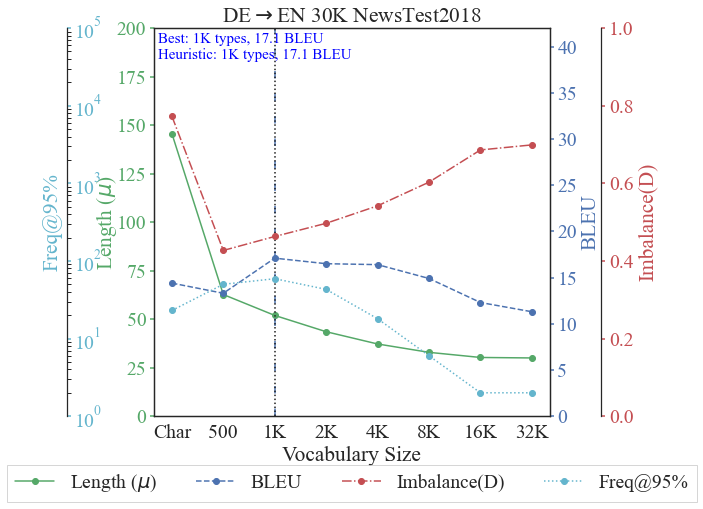

saving to viz/4axv-dev-deen-0.5m.pdf


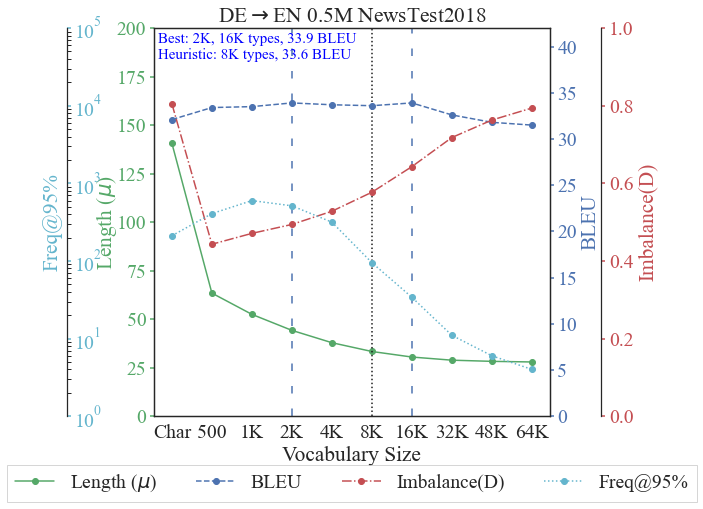

saving to viz/4axv-dev-deen-1m.pdf


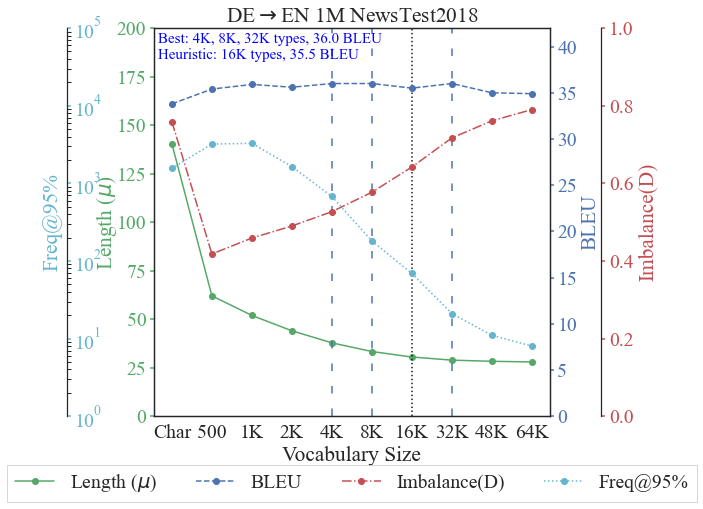

saving to viz/4axv-dev-deen-4.5m.pdf


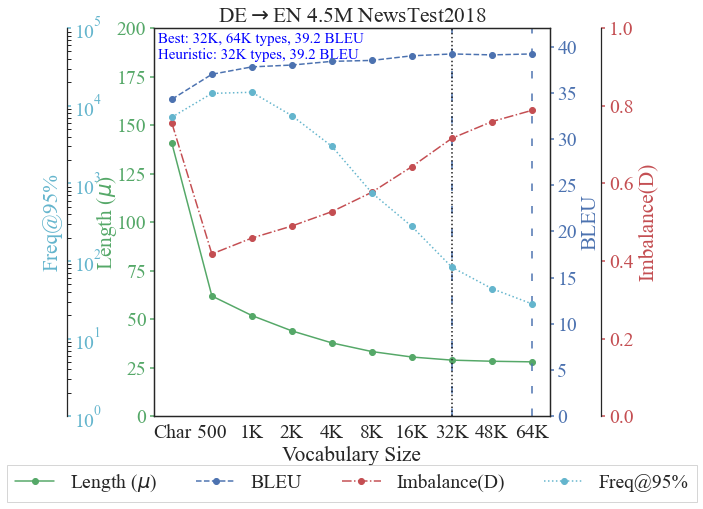

saving to viz/4axv-dev-ende-30k.pdf


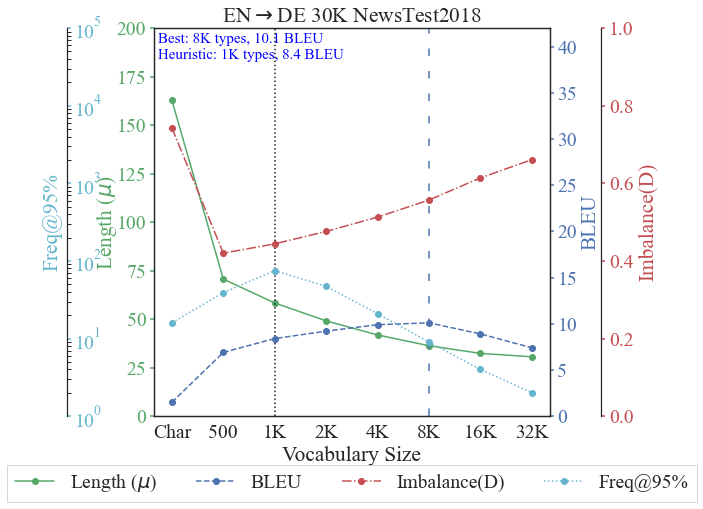

saving to viz/4axv-dev-ende-0.5m.pdf


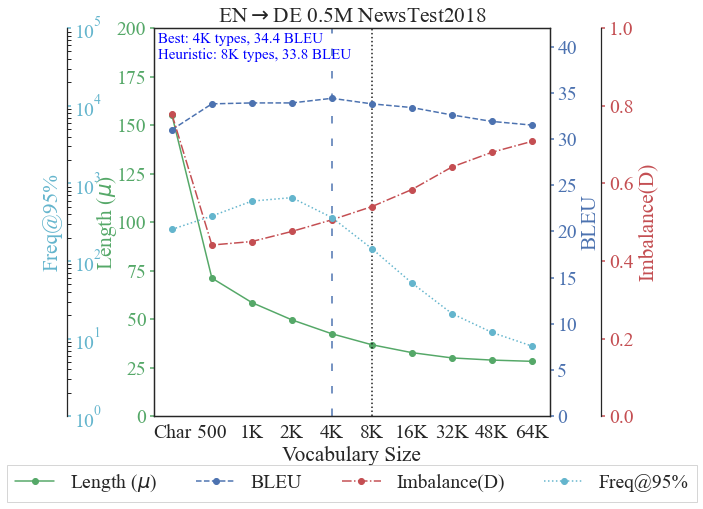

saving to viz/4axv-dev-ende-1m.pdf


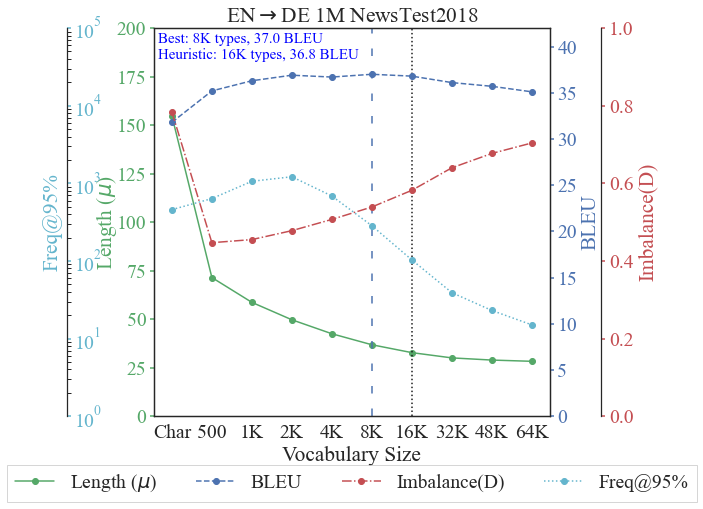

saving to viz/4axv-dev-ende-4.5m.pdf


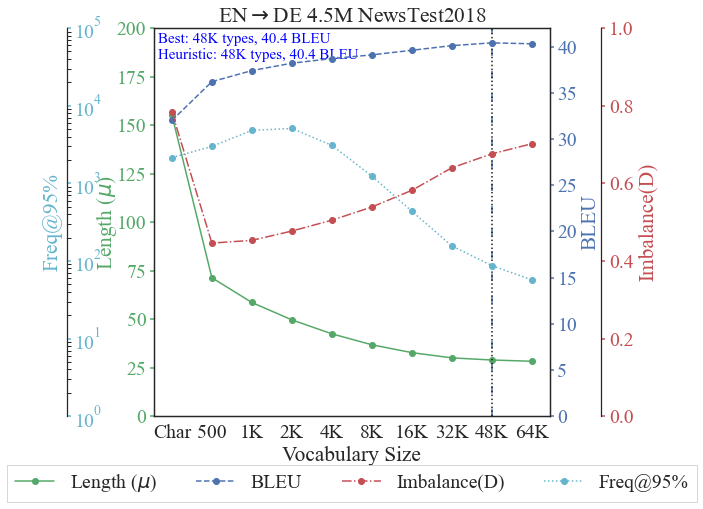

saving to viz/4axv-dev-enhi-0.5m.pdf


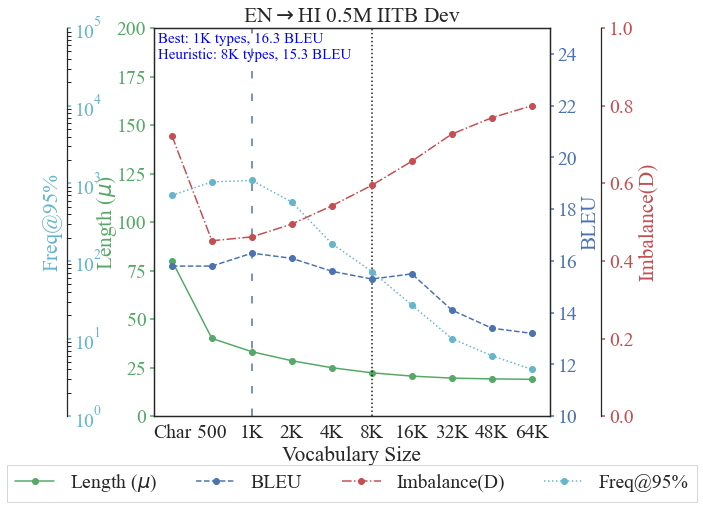

saving to viz/4axv-dev-enhi-1.3m.pdf


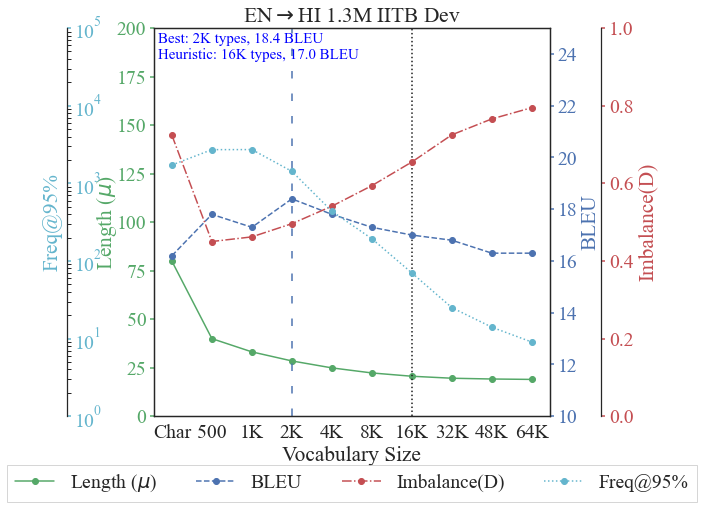

saving to viz/4axv-dev-enlt-0.6m.pdf


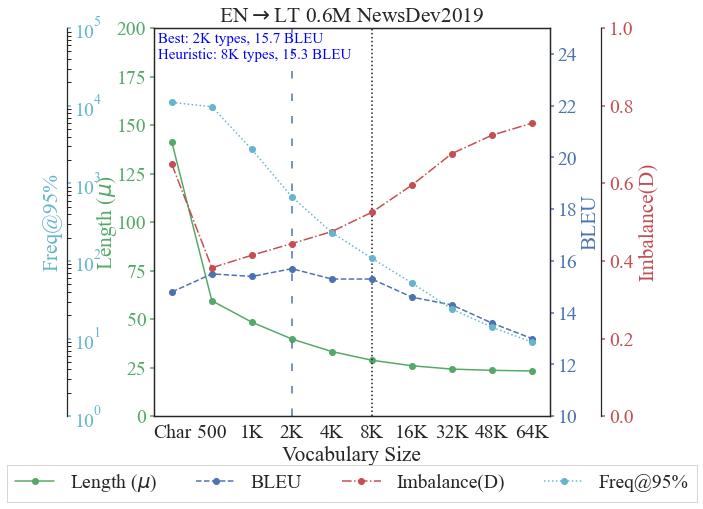

saving to viz/4axv-test-deen-30k.pdf


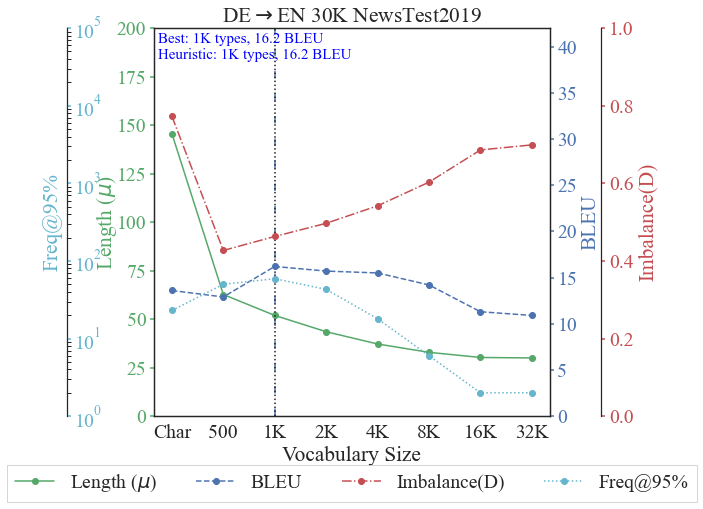

saving to viz/4axv-test-deen-0.5m.pdf


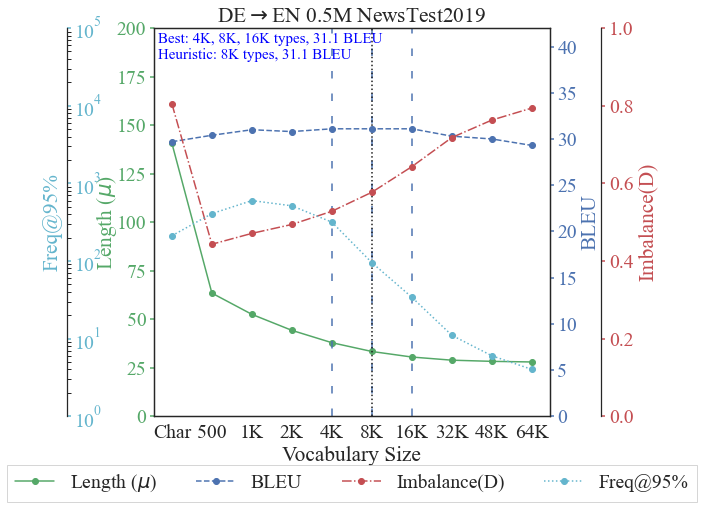

saving to viz/4axv-test-deen-1m.pdf


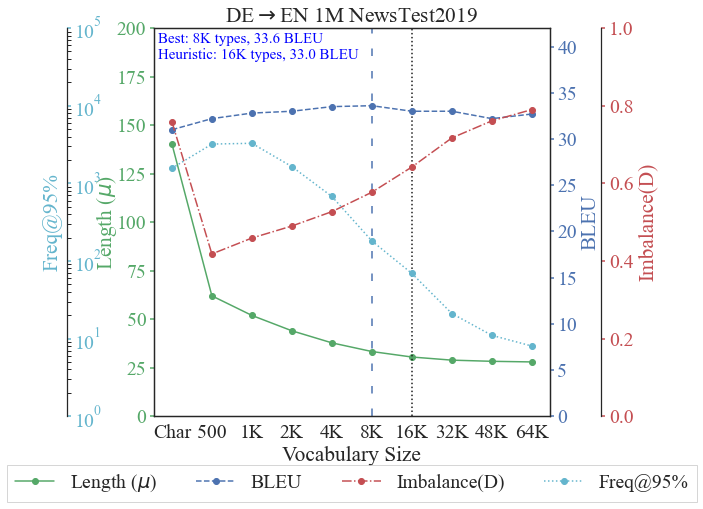

saving to viz/4axv-test-deen-4.5m.pdf


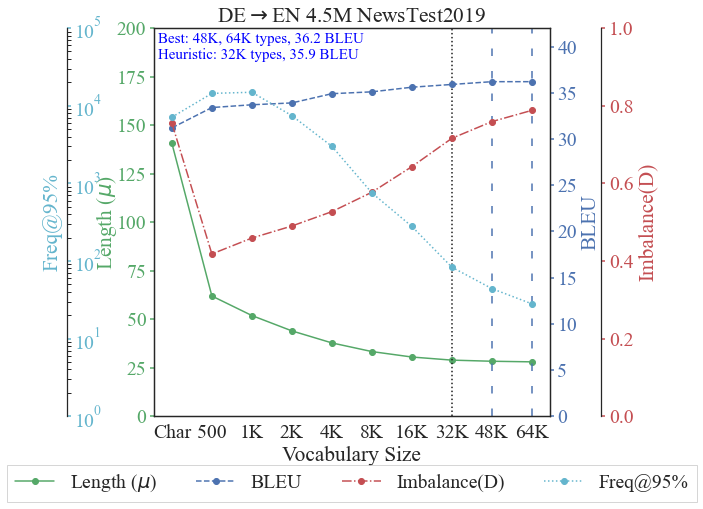

saving to viz/4axv-test-ende-30k.pdf


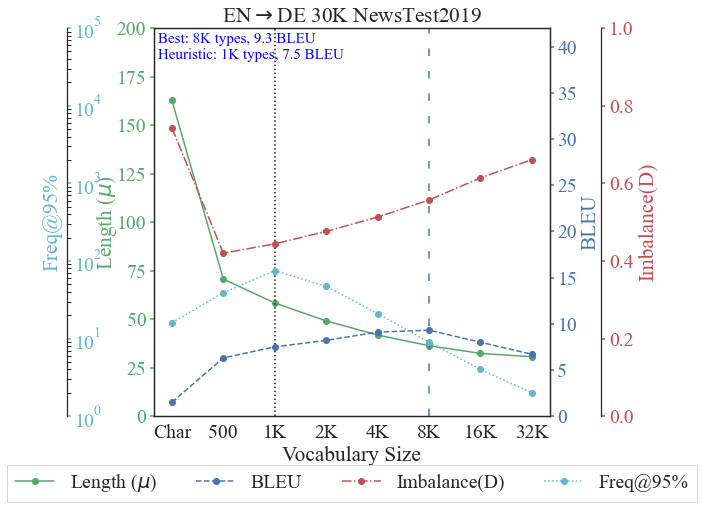

saving to viz/4axv-test-ende-0.5m.pdf


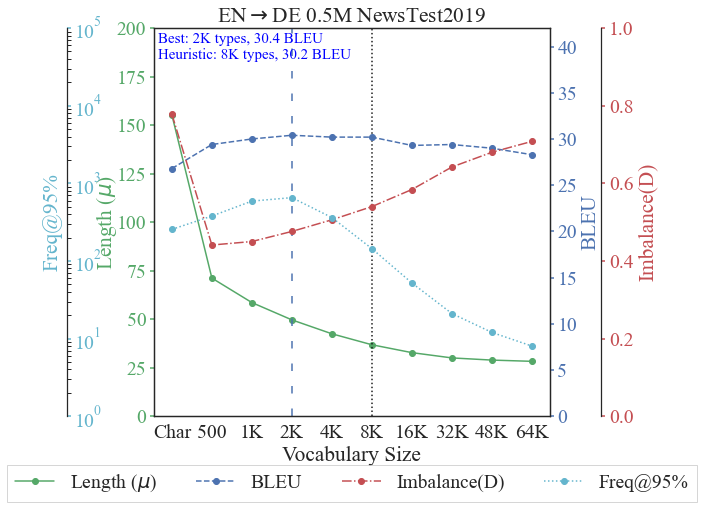

saving to viz/4axv-test-ende-1m.pdf


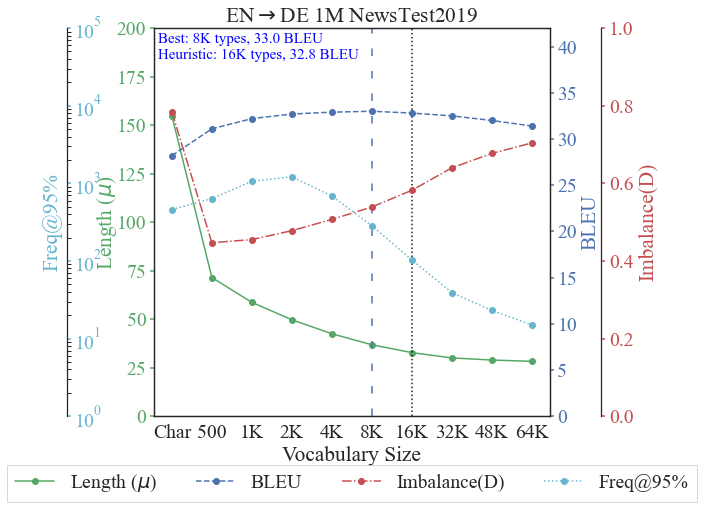

saving to viz/4axv-test-ende-4.5m.pdf


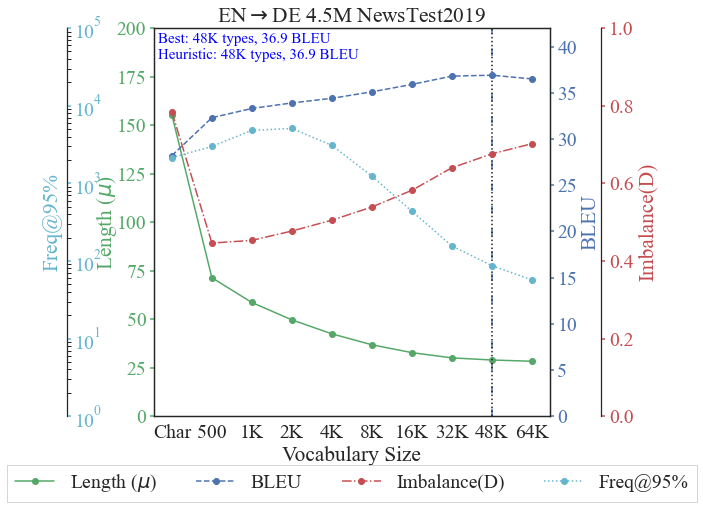

saving to viz/4axv-test-enhi-0.5m.pdf


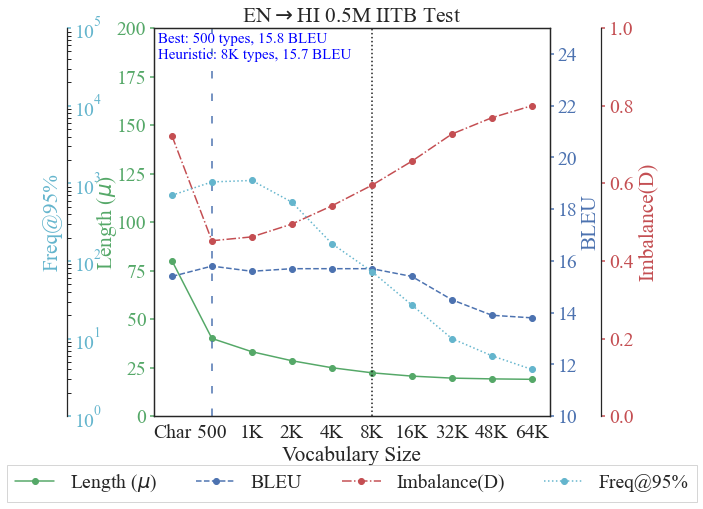

saving to viz/4axv-test-enhi-1.3m.pdf


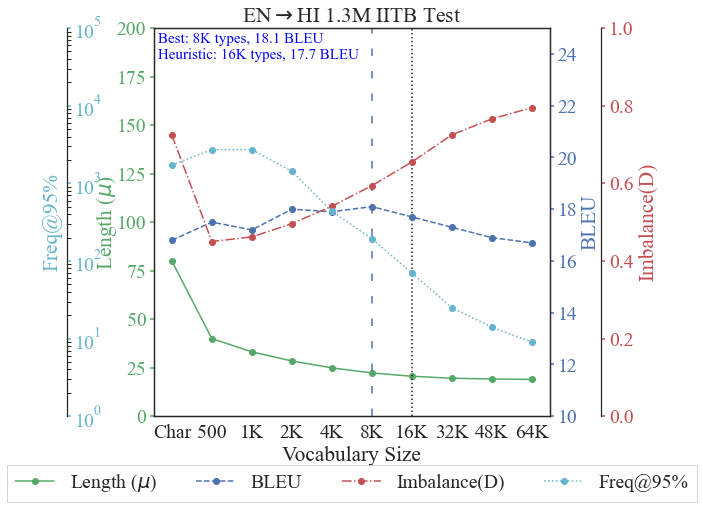

saving to viz/4axv-test-enlt-0.6m.pdf


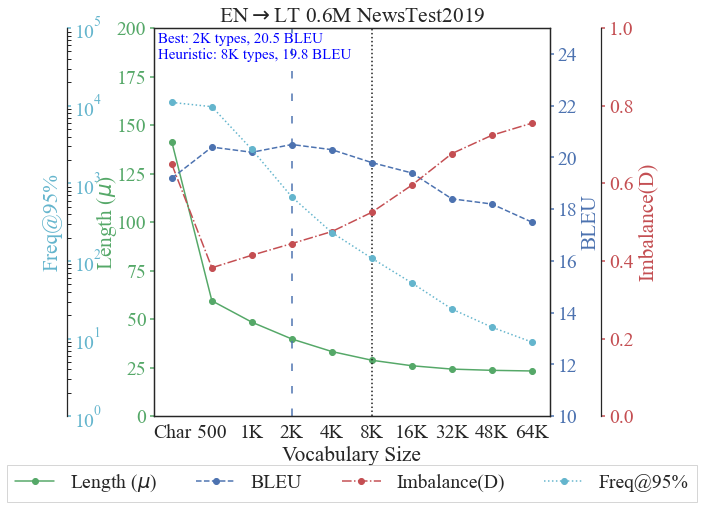

In [71]:
def four_axes_plot(x, y1, y2, y3, y4, legends, y_maxs=None, title=None, subtitle=None, y_mins=None, save=None, 
                    figsize=(10, 7), scales=['linear', 'linear', 'linear', 'linear'],
                    max_bleu_lines=None,  heuristic_lines=None, adjust=None):
    assert len(legends) == 5 # [x, y1, y2, y3, y4]

    fig, host = plt.subplots(figsize=figsize)
    fig.tight_layout()   
    fig.subplots_adjust(**adjust)

    par1 = host
    par2 = host.twinx()
    par3 = host.twinx()
    par4 = host.twinx()

    # Offset the right spine of par3.  The ticks and label have already been
    # placed on the right by twinx above.
    par3.spines["right"].set_position(("axes", 1.13))
    # Having been created by twinx, par3 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par3.spines["right"].set_visible(True)
    
    # 4th axis
    par4.spines["right"].set_position(("axes", -0.22))
    make_patch_spines_invisible(par4)
    par4.spines["right"].set_visible(True)

    p1, = par1.plot(x, y1, "g-o", label=legends[1])
    p2, = par2.plot(x, y2, "b--o", label=legends[2])
    p3, = par3.plot(x, y3, "r-.o", label=legends[3])
    p4, = par4.plot(x, y4, "c:o", label=legends[4])    

    y_mins = y_mins or [0] * 4
    y_maxs = y_maxs or [max(line) * 1.1 for line in [y1, y2, y3, y4]]
    assert len(y_maxs) == 4     
    assert len(y_mins) == 4 
    par1.set_ylim(y_mins[0], y_maxs[0])
    par2.set_ylim(y_mins[1], y_maxs[1])
    par3.set_ylim(y_mins[2], y_maxs[2])
    par4.set_ylim(y_mins[3], y_maxs[3])    

    par1.set_xlabel(legends[0])
    par1.set_ylabel(legends[1], labelpad=-2)
    par2.set_ylabel(legends[2])
    par3.set_ylabel(legends[3])
    par4.set_ylabel(legends[4], labelpad=-60)    

    par1.yaxis.label.set_color(p1.get_color())
    par2.yaxis.label.set_color(p2.get_color())
    par3.yaxis.label.set_color(p3.get_color())
    par4.yaxis.label.set_color(p4.get_color())

    assert len(scales) == 4
    for par, yscale in zip([par1, par2, par3, par4], scales):
        par.set_yscale(yscale)

    tkw = dict(size=4, width=1.5)
    par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par3.tick_params(axis='y', colors=p3.get_color(), **tkw)
    par4.tick_params(axis='y', colors=p4.get_color(), **tkw)    
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3, p4]
    if max_bleu_lines:
        for line in max_bleu_lines:
            par1.axvline(x=line, c='b', linestyle=(0, (5, 10)))
    if heuristic_lines:
        for line in heuristic_lines:
            par1.axvline(x=line, c='k', linestyle=':')

    host.legend(lines, [l.get_label() for l in lines], loc='upper center', ncol=4, 
                fancybox=False, bbox_to_anchor=(0.5,-0.1))


    if title:
        plt.title(title)
    if subtitle:
        par1.text(0.01, 0.99, subtitle,
            verticalalignment='top', horizontalalignment='left',
            transform=par1.transAxes,
            color='blue', fontsize=15)
    if save:
        print(f'saving to {save}')
        plt.savefig(save)
    plt.show()
    

def to_4ax_data(head, data, x, y1, y2, y3, y4):
    x_idx = head.index(x)
    y1_idx = head.index(y1)
    y2_idx = head.index(y2)
    y3_idx = head.index(y3)
    y4_idx = head.index(y4)    
    res = []
    for grp in data:
        buf = np.zeros((len(grp), 4), dtype=np.float)
        xs = [None] * len(grp)
        grp_name = None
        for i, ex in enumerate(grp):
            x = ex[x_idx]
            grp_name, x_name = x.split('/')
            xs[i] = x_name.split('-')[2]
            grp_name = grp_name.replace('runs-', '')
            buf[i, 0] = ex[y1_idx]
            buf[i, 1]= ex[y2_idx]
            buf[i, 2]= ex[y3_idx]
            buf[i, 3]= ex[y4_idx]
        res.append((grp_name, xs, buf))
    return res
    

sns.set(font="Times New Roman", style='white', font_scale=1.78)

def heuristic_select(freqs, threshold=100):
    """Heuristic used to select best vocab, based on freq@95% """
    # assumption frequences are sorted as increasing order of vocab size
    # traverse from right side i.e max vocab
    for i in range(len(freqs)-1, -1, -1):
        freq = freqs[i]
        if freq >= threshold:
            high = freq
            if i < len(freqs):
                low = freqs[i+1]
                # find nearest
                if abs(low - threshold) < abs(high - threshold):
                    return i+1
            return i
    # if all freqs are lower than threshold, return whatever max was found
    return np.argmax(freqs)

for split in ['dev', 'test']:
    fields = dict(y1='tgt_mean_len', y2=f'BLEU_{split}', y3='tgt_EMD', y4='tgt_f95p', x='Experiment')
    data_4ax = to_4ax_data(header, all_data, **fields)
    legends = ['Vocabulary Size'] + [r'Length ($\mu$)', 'BLEU', 'Imbalance(D)', 'Freq@95%']
    c = 0
    for name, xs, ys in data_4ax:
        xs = [vocab_name[x] for x in xs]
        name = name_name[name]
        y_mu, y_bleu, y_D, y_f = ys[:,0], ys[:,1], ys[:,2], ys[:,3]
        scales = ['linear', 'linear', 'linear', 'log']
        max_bleu, min_bleu = max(y_bleu), min(y_bleu)
        
        #max_bleu = 10 * math.ceil(max_bleu/10)
        set_name = ''
        if 'DE' in name:
            min_bleu, max_bleu = 0, 42
            set_name = 'NewsTest2018' if split == 'dev' else 'NewsTest2019'
        else:
            min_bleu, max_bleu = 10, 25
            if 'HI' in name:
                set_name = 'IITB Dev' if split == 'dev' else 'IITB Test'
            else:
                assert 'LT' in name
                set_name = 'NewsDev2019' if split == 'dev' else 'NewsTest2019'
        min_bleu = 10 * math.floor(min_bleu/10)

        y_maxs = [200, max_bleu, 1,  10 ** 5 ]
        y_mins = [0,   min_bleu, 0,  1]

        save_to = f'viz/4axv-{split}-'
        save_to += name.replace(r'$\rightarrow$', '').replace(' ', '-').lower() + '.pdf'
        name = f'{name} {set_name}'
        #save_to = None
        adjust=dict(bottom=0.17, left=0.25, top=0.94, right=0.8)
        

        max_bleu_lines = [i for i, v in enumerate(y_bleu) if abs(max(y_bleu) - v) <= 0.1]
        heur_idx = heuristic_select(y_f)
        best_vocabs = ", ".join(xs[i] for i in max_bleu_lines)
        
        subtitle = f'Best: {best_vocabs} types, {max(y_bleu)} BLEU\nHeuristic: {xs[heur_idx]} types, {y_bleu[heur_idx]:.1f} BLEU'
        four_axes_plot(x=xs, y1=y_mu, y2=y_bleu, y3=y_D, y4=y_f, title=name,
                        subtitle=subtitle,
                        legends=legends, y_maxs=y_maxs, y_mins=y_mins, scales=scales, 
                        save=save_to, adjust=adjust,
                        max_bleu_lines=max_bleu_lines,
                        heuristic_lines = [heur_idx])
        c += 1
        if c >= 1:
            #break
            pass

In [266]:
ar = np.array([1,2,3,4,5,4,3,3, 2])
m = max(ar)


[2, 3, 4, 5, 6, 7]